In [1]:
%pylab inline
from SimPEG import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SimPEG.Utils import io_utils

In [3]:
mshfile = 'MEsh_TEst.msh'

model_dir = '../../Geological_model/'

# Load mesh file
mesh = Mesh.TensorMesh.readUBC(model_dir+mshfile)

# Create our own mesh!
csx, csy, csz = 25., 25., 25.
ncx, ncy, ncz = 48, 48, 20
npad = 0
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
xc = 300+5.57e5
yc = 600+7.133e6
zc = 425.
x0_new = np.r_[mesh.x0[0]+xc, mesh.x0[1]+yc, mesh.x0[2]+zc]
mesh._x0 = x0_new

# Load in observation file
#[B,M,dobs] = PF.BaseMag.readUBCmagObs(obsfile)

# Read in topo surface
topsurf = model_dir+'CDED_Lake_Coarse.ts'
geosurf = [
    [model_dir+'Till.ts',True,True,0],
    [model_dir+'XVK.ts',True,True,1],
    [model_dir+'PK1.ts',True,True,2],
    [model_dir+'PK2.ts',True,True,3],
    [model_dir+'PK3.ts',True,True,4],
    [model_dir+'HK1.ts',True,True,5],
    [model_dir+'VK.ts',True,True,6]
]



In [4]:
import time as tm

modelInd = np.ones(mesh.nC)*-1
for ii in range(len(geosurf)):
    tin = tm.time()
    print "Computing indices with VTK: " + geosurf[ii][0]
    T, S = io_utils.read_GOCAD_ts(geosurf[ii][0])
    indx = io_utils.surface2inds(T,S,mesh, boundaries=geosurf[ii][1], internal=geosurf[ii][2])
    print "VTK operation completed in " + str(tm.time() - tin) + " sec"
    modelInd[indx] = geosurf[ii][3]

Computing indices with VTK: ../../Geological_model/Till.ts
Extracting indices from grid...
VTK operation completed in 6.47659087181 sec
Computing indices with VTK: ../../Geological_model/XVK.ts
Extracting indices from grid...
VTK operation completed in 1.02837395668 sec
Computing indices with VTK: ../../Geological_model/PK1.ts
Extracting indices from grid...
VTK operation completed in 2.8953909874 sec
Computing indices with VTK: ../../Geological_model/PK2.ts
Extracting indices from grid...
VTK operation completed in 1.0211019516 sec
Computing indices with VTK: ../../Geological_model/PK3.ts
Extracting indices from grid...
VTK operation completed in 1.29332900047 sec
Computing indices with VTK: ../../Geological_model/HK1.ts
Extracting indices from grid...
VTK operation completed in 2.54887104034 sec
Computing indices with VTK: ../../Geological_model/VK.ts
Extracting indices from grid...
VTK operation completed in 2.54360198975 sec


In [5]:
T, S = io_utils.read_GOCAD_ts(topsurf)
indx = io_utils.surface2inds(T,S, mesh, boundaries=True, internal=True) 
actv = np.zeros(mesh.nC)
actv[indx] = 1

modelInd[actv==0] = 7


Extracting indices from grid...


In [11]:
# Background density

def getModel(Till=0.0, XVK=2e-3, PK1=1e-3, PK2=1e-3, PK3=1e-3, HK1=5e-2, VK=5e-3, air=0., bkgr=0.):
    vals = [Till, XVK, PK1, PK2, PK3, HK1, VK, air]
    model= np.ones(mesh.nC) * bkgr

    for ii, sus in zip(range(8),vals):
        model[modelInd == ii] = sus
    return model
model = getModel()

In [7]:
mesh.writeUBC('VTKmesh.msh')

In [12]:
from ipywidgets.widgets import interact, IntSlider

<function __main__.slide>

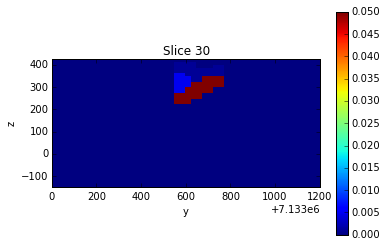

In [13]:
def slide(s,normal):
    colorbar(mesh.plotSlice(model, normal=normal, ind=s, clim=np.r_[model.min(), model.max()])[0])
    plt.gca().set_aspect('equal')
interact(slide, s=(0,60), normal=['X','Y','Z'])

In [14]:
print mesh

  ---- 3-D TensorMesh ----  
   x0: 556700.00
   y0: 7133000.00
   z0: -150.00
  nCx: 48
  nCy: 48
  nCz: 26
   hx: 48*25.00
   hy: 48*25.00
   hz: 20*25.00, 6*12.50


In [15]:
import simpegPF as PF
from simpegPF import BaseMag as MAG

In [16]:
# First we need to define the direction of the inducing field
# As a simple case, we pick a vertical inducing field of magnitude 50,000nT. 
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
H0 = (50000.,90.,0.)

actvMap = Maps.InjectActiveCells(mesh, actv==1, -100)

X, Y = np.meshgrid(mesh.vectorCCx, mesh.vectorCCy)
Z = X*0+mesh.vectorCCz[-1]

In [17]:
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = MAG.RxObs(rxLoc)
srcField = MAG.SrcField([rxLoc],H0)
survey = MAG.LinearSurvey(srcField)

In [18]:

actv_ind = np.where(actv==1)[0]

model = model[actv_ind]

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv_ind, -100)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=len(actv_ind))

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, mapping=idenMap, actInd=actv_ind)

# Pair the survey and problem
survey.pair(prob)


In [19]:

# Compute linear forward operator and compute some data
d = prob.fields(model)

Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



<matplotlib.colorbar.Colorbar instance at 0x112bf7d88>

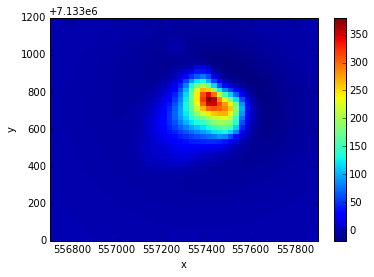

In [27]:
mesh2d = Mesh.TensorMesh([mesh.hx,mesh.hy],mesh.x0[:2])
colorbar(mesh2d.plotImage(d)[0])

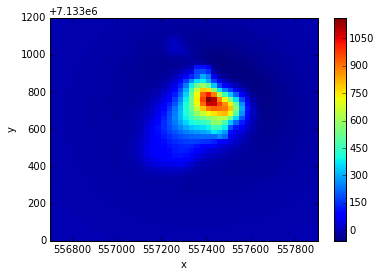

In [26]:
def createData(Till=0.0, XVK=2e-3, PK1=1e-3, PK2=1e-3, PK3=1e-3, HK1=5e-2, VK=5e-3, air=0., bkgr=0.):
    model = getModel(Till=Till, XVK=XVK, PK1=PK1, PK2=PK2, PK3=PK3, HK1=HK1, VK=VK, air=air, bkgr=bkgr)
    d = prob.fields(model)
    mesh2d = Mesh.TensorMesh([mesh.hx,mesh.hy],mesh.x0[:2])
    colorbar(mesh2d.plotImage(d)[0])

interact(createData, PK1=(0,0.01,0.0025), PK2=(0,0.01,0.0025), PK3=(0,0.01,0.0025))